In [ ]:
%%capture
! pip install stable_diffusion_videos[realesrgan]
! pip install diffusers
! pip install einops
! git config --global credential.helper store

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
import os
import inspect
from diffusers import StableDiffusionPipeline
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
from time import time
from PIL import Image
from einops import rearrange
import numpy as np
import torch
from torch import autocast
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from IPython.display import HTML,display
from base64 import b64encode
from typing import Callable, List, Optional, Union
from pathlib import Path
from torchvision.transforms.functional import pil_to_tensor
from torchvision.io import write_video
import librosa
@torch.no_grad()
def diffuse(
        pipe,
        cond_embeddings, # text conditioning, should be (1, 77, 768)
        cond_latents,    # image conditioning, should be (1, 4, 64, 64)
        num_inference_steps,
        guidance_scale,
        eta,
    ):
    torch_device = cond_latents.get_device()

    # classifier guidance: add the unconditional embedding
    max_length = cond_embeddings.shape[1] # 77
    uncond_input = pipe.tokenizer([""], padding="max_length", max_length=max_length, return_tensors="pt")
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, cond_embeddings])

    # if we use LMSDiscreteScheduler, let's make sure latents are mulitplied by sigmas
    if isinstance(pipe.scheduler, LMSDiscreteScheduler):
        cond_latents = cond_latents * pipe.scheduler.sigmas[0]

    # init the scheduler
    accepts_offset = "offset" in set(inspect.signature(pipe.scheduler.set_timesteps).parameters.keys())
    extra_set_kwargs = {}
    if accepts_offset:
        extra_set_kwargs["offset"] = 1
    pipe.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)
    # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
    # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
    # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
    # and should be between [0, 1]
    accepts_eta = "eta" in set(inspect.signature(pipe.scheduler.step).parameters.keys())
    extra_step_kwargs = {}
    if accepts_eta:
        extra_step_kwargs["eta"] = eta

    # diffuse!
    for i, t in enumerate(pipe.scheduler.timesteps):

        # expand the latents for classifier free guidance
        latent_model_input = torch.cat([cond_latents] * 2)
        if isinstance(pipe.scheduler, LMSDiscreteScheduler):
            sigma = pipe.scheduler.sigmas[i]
            latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # cfg
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1  
        if isinstance(pipe.scheduler, LMSDiscreteScheduler):
            cond_latents = pipe.scheduler.step(noise_pred, i, cond_latents, **extra_step_kwargs)["prev_sample"]
        else:
            cond_latents = pipe.scheduler.step(noise_pred, t, cond_latents, **extra_step_kwargs)["prev_sample"]

    # scale and decode the image latents with vae
    cond_latents = 1 / 0.18215 * cond_latents
    image = pipe.vae.decode(cond_latents)['sample']
   
    # generate output numpy image as uint8
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image[0] * 255).astype(np.uint8)

    return image

def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    """ helper function to spherically interpolate two arrays v1 v2 """

    if not isinstance(v0, np.ndarray):
        inputs_are_torch = True
        input_device = v0.device
        v0 = v0.cpu().numpy()
        v1 = v1.cpu().numpy()

    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1

    if inputs_are_torch:
        v2 = torch.from_numpy(v2).to(input_device)

    return v2

def visualize_video_colab(video_path):
    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)
def make_video_pyav(
    frames_or_frame_dir: Union[str, Path, torch.Tensor],
    audio_filepath: Union[str, Path] = None,
    fps: int = 30,
    audio_offset: int = 0,
    audio_duration: int = 2,
    sr: int = 22050,
    output_filepath: Union[str, Path] = "./output.mp4",
    glob_pattern: str = "*.jpg",
):
    # Torchvision write_video doesn't support pathlib paths
    output_filepath = str(output_filepath)

    if isinstance(frames_or_frame_dir, (str, Path)):
        frames = None
        for img in sorted(Path(frames_or_frame_dir).glob(glob_pattern)):
     
            frame = pil_to_tensor(Image.open(img)).unsqueeze(0)
            frames = frame if frames is None else torch.cat([frames, frame])
    else:

        frames = frames_or_frame_dir

    # TCHW -> THWC
    frames = frames.permute(0, 2, 3, 1)

    if audio_filepath:
        # Read audio, convert to tensor
        audio, sr = librosa.load(audio_filepath, sr=sr, mono=True, offset=audio_offset, duration=audio_duration)
        audio_tensor = torch.tensor(audio).unsqueeze(0)

        write_video(
            output_filepath,
            frames,
            fps=fps,
            audio_array=audio_tensor,
            audio_fps=sr,
            audio_codec="aac",
            options={"crf": "10", "pix_fmt": "yuv420p"},
        )
    else:
        write_video(output_filepath, frames, fps=fps, options={"crf": "10", "pix_fmt": "yuv420p"})

    return output_filepath


Here is an example of generating one image from one prompt using the Stable diffusion model. 



Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


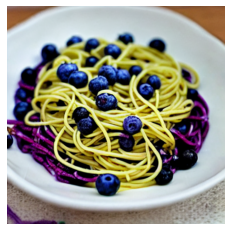

In [ ]:
# --------------------------------------
# args you probably want to change
prompts = ["blueberry spaghetti"], # prompts to dream about
seeds= [243],
gpu = 0, # id of the gpu to run on
name = 'berry_good_spaghetti', # name of this project, for the output directory
rootdir = './dreams',

# --------------------------------------
# args you probably don't want to change
num_inference_steps = 50,
guidance_scale = 7.5,
eta = 0.0,
width = 512,
height = 512,
# --------------------------------------
assert len(prompts) == len(seeds)
assert torch.cuda.is_available()
assert height % 8 == 0 and width % 8 == 0

# init the output dir
outdir = os.path.join(rootdir, name)
os.makedirs(outdir, exist_ok=True)


# init all of the models and move them to a given GPU
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16, use_auth_token=True)
torch_device = f"cuda:{gpu}"
pipe.unet.to(torch_device)
pipe.vae.to(torch_device)
pipe.text_encoder.to(torch_device)

# get the conditional text embeddings based on the prompts
prompt_embeddings = []
for prompt in prompts:   
    text_input = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    )
    with torch.no_grad():
        embed = pipe.text_encoder(text_input.input_ids.to(torch_device))[0]

    prompt_embeddings.append(embed)

# Take first embed and set it as starting point, leaving rest as list we'll loop over.
prompt_embedding_a = prompt_embeddings[0]

# Take first seed and use it to generate init noise
init_seed = seeds[0]

init_a = torch.randn(
    (1, pipe.unet.in_channels, height // 8, width // 8),
    device=torch_device,
    generator=torch.Generator(device='cuda').manual_seed(init_seed)
)

t = 0.01 #time step
cond_embedding = prompt_embedding_a
init = init_a

with autocast("cuda"):
    image = diffuse(pipe, cond_embedding, init, num_inference_steps, guidance_scale, eta)

#display the image
plt.figure()
plt.imshow(image)
plt.axis('off') 


1. Complete the following code (TODOs) such that it can generate image(s) that interpolate between two prompts. (Hint: use `slerp()`  provided above to interpolate between two prompts).
2. Write a for loop to generate a series of images named by frame000000.jpg, frame000001.jpg,  ... and use `make_video_pyav()` to compile them into a video
3. Do whatever you want

In [ ]:
# --------------------------------------
# args you probably want to change
prompts = ["blueberry spaghetti", "strawberry spaghetti"], # prompts to dream about
seeds=[243, 523],
gpu = 0, # id of the gpu to run on
name = 'berry_good_spaghetti', # name of this project, for the output directory
rootdir = './dreams',
num_steps = 72,  # number of steps between each pair of sampled points
# --------------------------------------
# args you probably don't want to change
num_inference_steps = 50,
guidance_scale = 7.5,
eta = 0.0,
width = 512,
height = 512,
# --------------------------------------
assert len(prompts) == len(seeds)
assert torch.cuda.is_available()
assert height % 8 == 0 and width % 8 == 0

# init the output dir
outdir = os.path.join(rootdir, name)
os.makedirs(outdir, exist_ok=True)

frame_index = 0

# TODO: interpolate cond_embedding between prompt_embedding_a and prompt_embedding_b at time t
cond_embedding = 

# TODO: interpolate between init_a and init_b at time t
init = 

with autocast("cuda"):
    # TODO: diffuse via pre-defined pipeline, cond_embedding, init and other parameters
    image = 

im = Image.fromarray(image)
outpath = os.path.join(outdir, 'frame%06d.jpg' % frame_index)
im.save(outpath)

#display the image
plt.figure()
plt.imshow(image)
plt.axis('off') 



In [ ]:
#optional: convert the images to a video and play it
visualize_video_colab(make_video_pyav(outdir))